## Imports

In [1]:
# import modules
from numba import jit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
from scipy.special import erf

In [2]:
cmap = matplotlib.cm.get_cmap('cividis').copy()

colors1 = plt.cm.inferno(np.linspace(0., 1, 128))
colors2 = plt.cm.viridis(np.linspace(0, 1, 106))

# combine them and build a new colormap
colors = np.vstack((colors1[:22:-1], colors2[4:]))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors[::-1])

## The plasma profiles

### Proxy for fusion-relevant

In [3]:

def profile(x, y, npt_x, npt_y, ne_peak=1, eps = 1, triang = 0, scale=2):

    x_aux = 4*((x - npt_x / 2)/(10*16*scale)+.1)

    x_profile = (1 + erf((1+triang)*x_aux)) * np.exp(-x_aux)

    return .75* ne_peak* x_profile * np.exp(-((y - npt_y / 2)/(10*16*scale * np.sqrt(2)*eps/4))**2)

### Plasma torch

In [4]:

def old_profile(x, y, npt_x, npt_y, ne_peak, stdev, beta, scale=2):
    aux1 = (x - npt_x / 2) / (np.sqrt(2) * stdev)
    aux2 = (y - npt_y / 2) / (np.sqrt(2) * stdev)
            
    return ne_peak * np.exp(-(aux1 * aux1 + aux2 * aux2))**beta

### Jet-like

In [5]:
from scipy.optimize import root_scalar
from mpl_toolkits.axes_grid1 import make_axes_locatable

def jet(angle, a, R0, delta, kappa):
    R = R0 + a*np.cos(angle + delta*np.sin(angle))
    z = kappa*a*np.sin(angle)

    return R, z

def inverse(R, z, R0, delta, kappa):
    
    def f(x, R=1, z=1, R0=1, delta=1, kappa=1, neg_side=False):
        theta = np.arcsin(z/(kappa*x))
        if neg_side:
            theta = np.pi - theta

        return x*np.cos(theta + delta*z/(kappa*x)) -R +R0

    try:
        a = root_scalar(f, args=(R, z, R0, delta, kappa), bracket=[abs(z/kappa)+1e-13, 2], method='brentq').root
        #The extra 1e-13 is to avoid the root finding algorithm to get stuck, as arcsin needs an argument between -1 and 1
        return a, np.arcsin(z/(kappa*a))
    
    except ValueError:
        try:
            #print('Were on the negative side')
            a = root_scalar(f, args=(R, z, R0, delta, kappa, True), bracket=[abs(z/kappa)+1e-13, 2], method='brentq').root
            return a, np.pi - np.arcsin(z/(kappa*a))
    
        except ValueError:
            return 2, np.pi

def jet_profile(a, theta, amplitude=.25, mode_num=4, phase=0.):
    if a>1:
        #This is to avoid the plasma extending beyond the last closed flux surface
        return 0 
    
    elif a< .8:
        #Inside, the density follows the flux surfaces to 1st order
        return np.sqrt(1-a) 
    
    else:
        #between around a=.8 to a=1, we add a perturbation, gaussian in a, sinusoidal in theta
        argument = (mode_num*theta + phase/mode_num if mode_num!=0 else 0)
        return np.sqrt(1-a) + amplitude * np.cos(argument)* np.exp(-((a-.9)/.04)**2) 
    

def make_density(R, z, R0, ne_peak, delta, kappa, profile=jet_profile, amplitude=.25, mode_num=4, phase=0.):

    grid = np.zeros((len(z), len(R)))
    outer_contour_R, outer_contour_z = jet(np.linspace(0, 2*np.pi, 200), 1, R0, delta, kappa)
    RM, Rm, zM, zm = np.amax(outer_contour_R), np.amin(outer_contour_R), np.amax(outer_contour_z), np.amin(outer_contour_z)

    

    for i, R_val in enumerate(R):
        for j, z_val in enumerate(z):
            if R_val > RM or R_val < Rm or z_val > zM or z_val < zm:
                continue
            else:
                contour_value, theta = inverse(R_val, z_val, R0, delta, kappa)
                grid[j, i] = ne_peak *profile(contour_value, theta, amplitude, mode_num, phase)
                # use grid[i, j] to rotate and send from HFS
                # use grid[-i, j] to rotate and send from LFS


    return grid

def transform(angle, a, R0, delta, kappa, scale):
    R2, z2 = jet(angle, a, R0, delta, kappa)
    R2 *= 53.4 * scale #The plasma extends from R=2 to 4, which is from 1/3 to 2/3 of the integration domain. 
    z2 *= 53.4 * scale
    z2 += 160 * scale
    return R2, z2


## Further simulation setup functions

### Antenna for wave excitation

In [6]:
@jit
def make_antenna_profile(npt_y, xs, w0, source, bb):
    
    for y in range(2, npt_y - 1, 2):
        
        aux = (npt_y / 2 - y) / w0
        
        aux1 = 0.75 * np.exp(-aux * aux) * 20 # gaussian envelope
        
        # excite Bz component (odd - odd)
        bb[int(xs + 1), y + 1] += 2 * source * aux1

### Background magnetic field

In [7]:
@jit
def make_B0(npt_x, npt_y, cntrl_para, b0):
    for x in range(0, npt_x - 1, 2):
        for y in range(0, npt_y - 1, 2):
            b0[x + 1, y + 1] = cntrl_para # B0z

### Apply absorbing boundary conditions

In [8]:
@jit
def absorbers(depth, npt_x, npt_y, ee, bb, jj, b0): # depth -> depth of the absorbing region
    # absorbers on the left boundary
    for x in range(2, depth + 1):
        for y in range(2, npt_y - 1):
            
            ee[x, y] *= 0.985
            bb[x, y] *= 0.985
            jj[x, y] *= 0.985
            b0[x, y] *= 0.985
            
    # absorbers on the right boundary
    for x in range(npt_x - depth + 1, npt_x - 1):
        for y in range(2, npt_y - 1):
            
            ee[x, y] *= 0.98
            bb[x, y] *= 0.98
            jj[x, y] *= 0.98
            b0[x, y] *= 0.98
            
    # absorbers on top/bottom boundaries
    for x in range(2, npt_x - 1):
        for y in range(2, npt_y + 1):
            
            if (y < depth) or (y > npt_y - depth):
                ee[x, y] *= 0.962
                bb[x, y] *= 0.962
                jj[x, y] *= 0.962
                b0[x, y] *= 0.962

### Update the equations for the fields

In [9]:
@jit
def update_equations(npt_x, npt_y, dt, aux_jp,
                     ee, bb, jj, b0, epsilon_r):
    
    for x in range(2, npt_x - 1, 2):
        for y in range(2, npt_y - 1, 2):
            
            # Jx component (odd - even)
            jj[x + 1, y] += dt * (
                4 * np.pi**2 * ee[x + 1, y] * aux_jp[x, y]
                - 4 * np.pi**2 * jj[x, y + 1] * b0[x + 1, y + 1] # + Jy * B0z
            ) 
            
            # Jy component (even - odd)
            jj[x, y + 1] += dt * (
                4 * np.pi**2 * ee[x, y + 1] * aux_jp[x, y]
                - 4 * np.pi**2 * (- jj[x + 1, y] * b0[x + 1, y + 1]) # - Jx * B0z
            )
                                 
            
            
            # Bz component (odd - odd)
            # dBz/dt = dEx/dy - dEy/dx - Jx
            bb[x + 1, y + 1] += - 0.5 * ((ee[x + 2, y + 1] - ee[x, y + 1]) 
                                         - (ee[x + 1, y + 2] - ee[x + 1, y])) / epsilon_r[x, y]
            
            
            # Ex component (odd - even)
            # dEx/dt = dBz/dy
            ee[x + 1, y] += 0.5 * (bb[x + 1, y + 1] - bb[x + 1, y - 1]) - dt * jj[x + 1, y]
            
            
                
            # Ey component (even - odd)
            # dEy/dt = -dBz/dx - Jy
            ee[x, y + 1] += - 0.5 * (bb[x + 1, y + 1] - bb[x - 1, y + 1]) - dt * jj[x, y + 1]           

### Power at the receiving antenna ($E_{norm}^2$)



In [10]:
@jit
def power_receving_antenna(npt_y, xr, ee, dens):
    
    for y in range(2, npt_y - 1, 2):
        
        # calculate power as
        # sqrt(Ex^2 + Ey^2)
        aux = np.sqrt(ee[int(xr + 1), y] * ee[int(xr + 1), y] + 
                     ee[int(xr), y + 1] * ee[int(xr), y + 1])
        
        # time average
        dens[y] = dens[y] * 0.9995 + 0.0005 * aux * aux

### Poynting vector Py

In [11]:
@jit
def poynting_vector_Py(npt_y, xr, ee, bb, dens):
    
    for y in range(2, npt_y - 1, 2):
        
        # calculate Poynting vector Py
        # Py = - Ex * Hz + Ez * Hx
        aux = - ee[int(xr + 1), y] * bb[int(xr + 1), y + 1]
        
        # time average
        dens[y] = dens[y] * 0.9995 + 0.0005 * aux * aux

### Define the quartz tube

In [12]:
@jit
def quartz_tube(quartz, npt_x, npt_y, wavelength, n_period, epsilon_r):
    R1 = ((27 / 2) / wavelength) * n_period # inner radius
    R2 = ((30 / 2) / wavelength) * n_period # outer radius
    
    for x in range(0, npt_x + 1):
        for y in range(0, npt_y + 1):
            aux1 = (x - npt_x / 2)
            aux2 = (y - npt_y / 2)
            R = np.sqrt(aux1**2 + aux2**2)
            
            if (quartz == 1) and (R >= R1) and (R <= R2):
                epsilon_r[x, y] = 3.75 # value from comsol
            else:
                epsilon_r[x, y] = 1

## Set-up the simulation parameters

In [55]:
# input parameters
scale = 2 # variable to scale the code

situation = 2 # 0 -> plasma torch, 1 -> fusion proxy, 2 -> JET-like profile

# background magnetic field strength
cntrl_para = 0.0 # set to 0 for O-mode

"""------------------------------------------"""

# plasma profile

#for the plasma torch
plasma_width = 10 # plasma width in mm
exponent = 2 # exponent for supergaussian

#for the fusion proxy
eps=1.3 
triang=.4

#for the JET-like profile

ne_peak = .4        # peak plasma density (normalised to cutoff density)

R0 = 3.15              # centre of the plasma profile
delta = .4       # triangularity
kappa = 1.5        # elongation

amplitude = .25    # amplitude of the plasma perturbation
mode_num = 4        # mode number of the plasma perturbation
phase = 6.28         # phase of the plasma perturbation

"""------------------------------------------"""



'------------------------------------------'

In [56]:
# number of points in the horizontal direction
Nx = 640 * scale 

# number of points in the vertical direction
Ny = 640 * scale

# grid points per period
n_period = 16 * scale

# simulation time steps
t_end = 100 * n_period

# time step to start recording power at receiving antenna plane
t_power = 20 * n_period

# probing frequency in GHz
fo = 208 # GHz

# wavelength in meters
lambda_0 = sp.constants.c / (fo * 10**9)

# wavelength in mm
wavelength = lambda_0 * 10**3

# beam waist 
w0 = 2. / wavelength * n_period

# length step in fdtd code
dx = 1 / (n_period / 2)

# effective stime step in fdtd code
dt = 1 / (2 * (n_period / 2))

# time step for antenna excitation
dt_1 = 1 / n_period

fwhm = ((plasma_width / 1.7) / wavelength) * n_period # fwhm and standard deviation of Gaussian plasma
stdev = fwhm / (2 * np.sqrt(2 * np.log(2)))

# define fields
EE = np.zeros((Nx + 4, Ny + 4)) # electric field
BB = np.zeros((Nx + 4, Ny + 4)) # magnetic field
JJ = np.zeros((Nx + 4, Ny + 4)) # current density
B0 = np.zeros((Nx + 4, Ny + 4)) # background magnetic field 
EPSILON_R = np.zeros((Nx + 4, Ny + 4)) # relative permittivity for quartz tube


# array to monitor power at receiving antenna plane
dens = np.zeros(Ny + 4)

# quartz tube outer radius
R_outer = ((30 / 2) / wavelength) * n_period

# emitting antenna position
xs = np.floor(Nx / 2 - R_outer - n_period)

# receiving antenna position
xr = np.ceil(Nx / 2 + R_outer + n_period)

# ensure antennas are located at even grid points
if xs % 2 != 0:
    xs -= 1
    
if xr % 2 != 0:
    xr += 1

## Calculate electromagnetic wave propagation

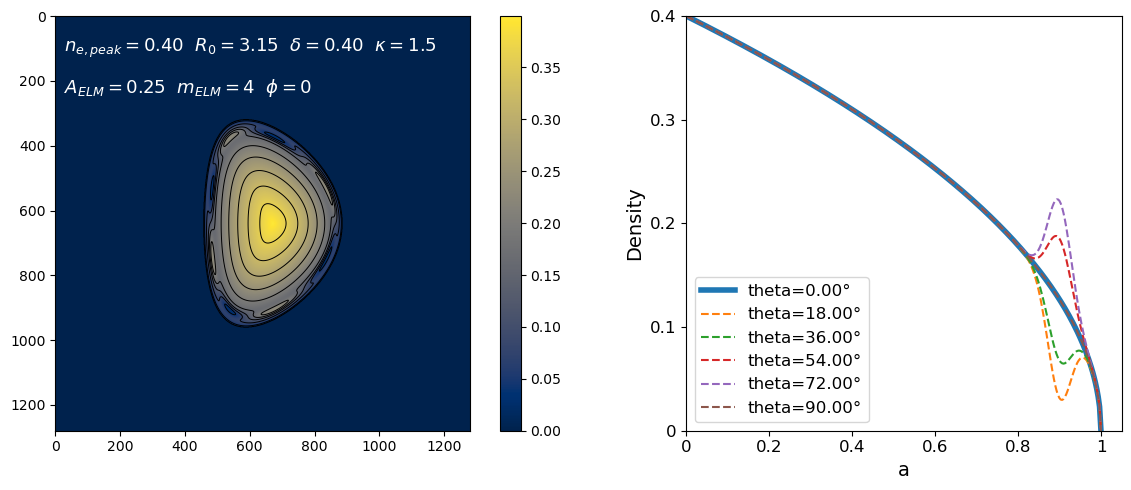

In [59]:
#create the plasma profile initially
if situation == 0:

    quartz=1 # quartz -> 0, 1 include quartz (1) or not (0)

    x2 = np.arange(0, 40*n_period, 1)

    X, Y = np.meshgrid(x2, x2)

    aux_jp = old_profile(X, Y, Nx, Ny, ne_peak, stdev, exponent, scale)
    
    
elif situation == 1:

    quartz=0

    x2 = np.arange(0, 40*n_period, 1)

    X, Y = np.meshgrid(x2, x2)

    aux_jp = profile(X, Y, Nx, Ny, ne_peak, eps, triang, scale)

elif situation == 2:

    quartz=0

    R = np.linspace(0, 6, 40*n_period)
    z = np.linspace(-3, 3, 40*n_period)

    aux_jp = make_density(R,z, R0, ne_peak, delta, kappa, jet_profile, amplitude, mode_num, phase)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    cont= ax[0].imshow(aux_jp, cmap='cividis')
    ax[0].contour(aux_jp, 10, colors='black', linewidths=0.7)
    ax[0].set_aspect('equal')
    ax[0].annotate(r'$n_{e,peak}=0.40$  $R_0=3.15$  $\delta=0.40$  $\kappa=1.5$',
                    xy=(0.02, 0.95), xycoords='axes fraction', fontsize=13, ha='left', va='top', c='white')
    ax[0].annotate(r'$A_{ELM}=0.25$  $m_{ELM}=4$  $\phi=0$', xy=(0.02, 0.8), xycoords='axes fraction', fontsize=13, ha='left', va='bottom', c='white')
    divider_1 = make_axes_locatable(ax[0])
    cax = divider_1.append_axes("right", size="5%", pad=0.3)

    plt.colorbar(cont, cax=cax)
    
    angle = np.linspace(0.01, 2*np.pi, 200)
    R2, z2 = transform(angle, 1, R0, delta, kappa, scale)
    #ax[0].plot(R2*2, z2*2, color='black', linewidth=1)
    
    a_vals= np.linspace(0, 1, 300)
    thetas = np.linspace(0, np.pi/2, 6)
    prof = np.array([[ne_peak*jet_profile(a, theta, amplitude, mode_num, phase) for a in a_vals] for theta in thetas])
    for i in range(len(thetas)):
        if i == 0:
            ax[1].plot(a_vals, prof[i], linewidth=4, label=f'theta={(thetas[i]/np.pi*180):.2f}°')
        else:
            ax[1].plot(a_vals, prof[i], linewidth=1.5, linestyle='--', label=f'theta={(thetas[i]/np.pi*180):.2f}°')
    ax[1].set_xlabel('a', fontsize=14)
    ax[1].set_ylabel('Density', fontsize=14)
    ax[1].set_yticks([0, .1, .2, .3, .4])
    ax[1].set_xticks([0, .2, .4, .6, .8, 1])
    ax[1].set_xticklabels([0, .2, .4, .6, .8, 1], fontsize=12)
    ax[1].set_yticklabels([0, .1, .2, .3, .4], fontsize=12)
    ax[1].set_ylim([0, .4])
    ax[1].set_xlim(0)
    ax[1].set_aspect(2.5)
    ax[1].legend(loc='lower left', fontsize=12)
    plt.tight_layout()
    plt.savefig('01_files/figures/jet_profile.pdf', dpi=300)

    

"""------------------------------------------"""

make_B0(Nx, Ny, cntrl_para, B0)

quartz_tube(quartz, Nx, Ny, wavelength, n_period, EPSILON_R)

# omega_t = omega * t
omega_t = 0

In [60]:
%%time

"""----------MAIN LOOP----------"""


for t_int in range(0, t_end + 1):
    
    aux = t_int / 140
    
    t_rise = 1 - np.exp(-aux * aux)
    
    omega_t += 2 * np.pi * dt_1
    
    if (omega_t > 2 * np.pi):
        omega_t -= 2 * np.pi
    
    source = np.sin(omega_t) * t_rise / 1.4
    
    # excite magnetic field
    make_antenna_profile(Ny, xs, w0, source, BB)    
            
    # apply the absorbing boundary conditions
    absorbers(int(3 * n_period), Nx, Ny, EE, BB, JJ, B0)
    
    # update equations
    update_equations(Nx, Ny, dt, aux_jp, 
                     EE, BB, JJ, B0, EPSILON_R)
    
    # monitor power
    if t_int > t_power:
        
        power_receving_antenna(Ny, xr, EE, dens)
        #poynting_vector_Py(Ny, xr, EE, BB, dens)

np.savetxt(f'01_files/{situation}_{scale}_{R0}_{delta}_{kappa}_{amplitude}_{mode_num}.txt', dens[3*n_period:-3*n_period:2])
print('Code finished successfuly') 

Code finished successfuly
CPU times: total: 10.3 s
Wall time: 30.1 s


## Plot results

In [61]:

# make circles to represent quartz tube
radius_1 = ((27 / 2) / wavelength) * n_period
radius_2 = ((30 / 2) / wavelength) * n_period

inner_radius = np.zeros((Nx, Ny))
outer_radius = np.zeros((Nx, Ny))
for x in range(Nx):
    for y in range(Ny):
        inner_radius[x, y] = (x - Nx / 2)**2 + (y - Ny / 2)**2 - radius_1**2
        outer_radius[x, y] = (x - Nx / 2)**2 + (y - Ny / 2)**2 - radius_2**2
        
        
# create a mock plasma profile      

plasma_radius = np.zeros((Nx, Ny))
for x in range(2, Nx - 2, 2):
    for y in range(2, Ny - 2, 2):
        #plasma_radius[x][y] = (x - x_max/2)**2 + (y - y_max/2)**2 - plasma_r**2
        plasma_radius[x, y] = ne_peak * np.exp(-(((x - Nx / 2)**2) / (2 * stdev**2) +  
                                                ((y - Ny / 2)**2) / (2 * stdev**2))**int(exponent))


C:\Users\ewout\AppData\Local\Temp\ipykernel_161248\4224962436.py:73: UserWarning: No contour levels were found within the data range.
  ax2.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)
C:\Users\ewout\AppData\Local\Temp\ipykernel_161248\4224962436.py:75: UserWarning: No contour levels were found within the data range.
  ax3.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)


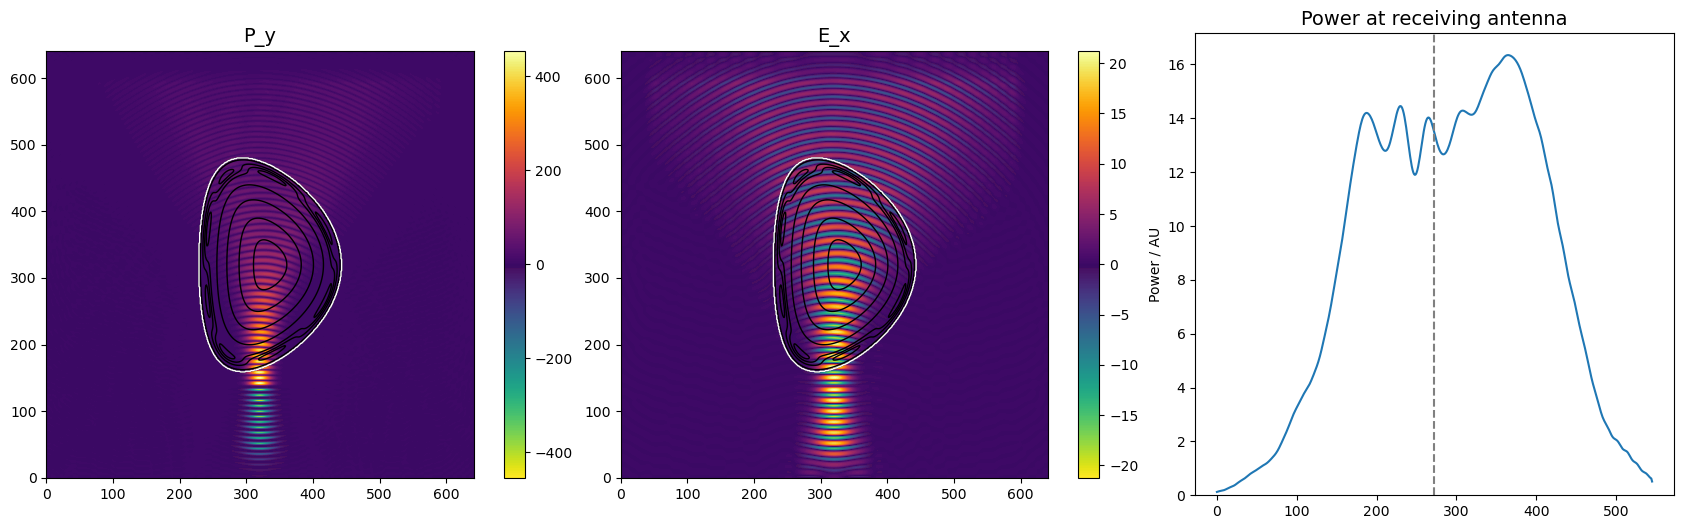

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(1, 3)

plt.figure(figsize = (21, 6), dpi = 100)

# power at receiving antenna
ax1 = plt.subplot(gs[0, 2])
ax1.plot(dens[3*n_period:-3*n_period:2])
ax1.set_title('Power at receiving antenna', fontsize = 14)
ax1.axvline(x = Nx/4-1.5*n_period, color = 'grey', linestyle = '--')
ax1.set_ylabel('Power / AU')
ax1.set_ylim(0)
#ax1.legend(loc='upper right', fontsize=15)

# contourf of |E|
ax2 = plt.subplot(gs[0, 1])

M = np.amax(np.abs(EE[::2, 1::2]))
cf = ax2.contourf(EE[::2, 1::2], vmax=M, vmin=-M, levels=200, cmap=mymap, extend='max')
ax2.set_title(r'E_x', fontsize = 14)
ax2.set_aspect('equal')

divider_1 = make_axes_locatable(ax2)
cax = divider_1.append_axes("right", size="5%", pad=0.3)

norm_1 = matplotlib.colors.Normalize(vmin=-M, vmax=M)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm_1, cmap=mymap), cax=cax)

ax3 = plt.subplot(gs[0, 0])
px =  -EE[1::2, ::2] * BB[1::2, 1::2]
py = EE[::2, 1::2] * BB[1::2, 1::2]
power_dens = EE[::2, 1::2]**2 + BB[1::2, 1::2]**2
Mx, mx = np.amax(px), np.amin(px)
My, my = np.amax(py), np.amin(py)
M3, m3 = np.amax(power_dens), np.amin(power_dens)
cf_extra = ax3.contourf(py, vmax=My, vmin=-My, levels=200, cmap=mymap, extend='max')
ax3.set_title(r'P_y', fontsize = 14)
ax3.set_aspect('equal')

divider_2 = make_axes_locatable(ax3)
cax = divider_2.append_axes("right", size="5%", pad=0.3)
norm = matplotlib.colors.Normalize(vmin=-My, vmax=My)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=mymap), cax=cax)


if situation == 0:
# plot circles to represent the quartz tube
    ax2.contour(inner_radius[::2, ::2], levels = 0)
    ax2.contour(outer_radius[::2, ::2], levels = 0)
    ax3.contour(inner_radius[::2, ::2], levels = 0)
    ax3.contour(outer_radius[::2, ::2], levels = 0)
    
    cf1 = ax2.contour(plasma_radius[::2, ::2], levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
    cf2 = ax2.contour(plasma_radius[::2, ::2], levels=[.01], colors='white', linewidths=1)
    cf3 = ax3.contour(plasma_radius[::2, ::2], levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
    cf4 = ax3.contour(plasma_radius[::2, ::2], levels=[.01], colors='white', linewidths=1)

elif situation == 1:

    x2 = np.arange(0, 20*n_period, 1)
    X, Y = np.meshgrid(x2, x2)

    ax2.contour(profile(X, Y, Nx/2, Ny/2, scale=scale/2, eps=eps, triang=triang), levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
    ax2.contour(profile(X, Y, Nx/2, Ny/2, scale=scale/2, eps=eps, triang=triang), levels=[.01], colors='white', linewidths=1)
    ax3.contour(profile(X, Y, Nx/2, Ny/2, scale=scale/2, eps=eps, triang=triang), levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
    ax3.contour(profile(X, Y, Nx/2, Ny/2, scale=scale/2, eps=eps, triang=triang), levels=[.01], colors='white', linewidths=1)

elif situation == 2:

    ax2.contour(aux_jp[::2, ::2], levels=8, colors='black', linewidths=1)
    ax2.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)
    ax3.contour(aux_jp[::2, ::2], levels=8, colors='black', linewidths=1)
    ax3.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)

plt.savefig(f'01_files/figures/{situation}_amplitude_{amplitude}.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ewout\AppData\Local\Temp\ipykernel_161248\398389407.py:19: RuntimeWarning: invalid value encountered in true_divide
  u_norm = u / length * magnitude
C:\Users\ewout\AppData\Local\Temp\ipykernel_161248\398389407.py:20: RuntimeWarning: invalid value encountered in true_divide
  v_norm = v / length * magnitude


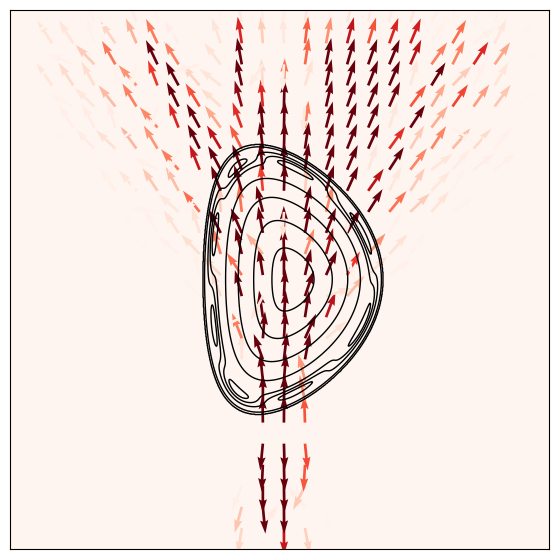

In [66]:
fig, ax = plt.subplots(figsize = (7,7), dpi = 100)

x2 = np.arange(0, 40*n_period, 25)

X2, Y2 = np.meshgrid(x2, x2)

power_dens = EE[::25, 1::25]**2 + BB[1::25, 1::25]**2
threshold = .0

px = -EE[1::25, ::25] * BB[1::25, 1::25]
py = EE[::25, 1::25] * BB[1::25, 1::25]

# Define the vector field
u = np.where(power_dens > threshold, px, 0)
v = np.where(power_dens > threshold, py, 0)
magnitude = 1  # fixed length of vectors

length = np.sqrt(u**2 + v**2)
u_norm = u / length * magnitude
v_norm = v / length * magnitude

# Plot the vector field
ax.quiver(X2, Y2, u_norm, v_norm, power_dens, scale=20, cmap='Reds', clim=[0, Mx], width=.005, label='Poynting vector')


newmap =matplotlib.cm.get_cmap('Reds')
# Show the plot
ax.set_aspect('equal')
ax.set_facecolor(newmap(0))
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

if situation == 0:
# plot circles to represent the quartz tube
    ax.contour(inner_radius[::2, ::2], levels = 0)
    ax.contour(outer_radius[::2, ::2], levels = 0)
    
    cf1 = ax.contour(plasma_radius[::2, ::2], levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
    cf2 = ax.contour(plasma_radius[::2, ::2], levels=[.01], colors='black', linewidths=1)

elif situation == 1:

    x3 = np.arange(0, 40*n_period, 1)

    X3, Y3 = np.meshgrid(x3, x3)

    ax.contour(profile(X3, Y3, Nx, Ny, scale=scale, eps=eps, triang=triang), levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
    ax.contour(profile(X3, Y3, Nx, Ny, scale=scale, eps=eps, triang=triang), levels=[.01], colors='black', linewidths=1)

elif situation == 2:
    ax.contour(aux_jp, levels=8, colors='black', linewidths=1)
 
plt.show()

